#### Name: `Jike Lu`
#### AndrewID: `jikelu`

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

tar: spark-3.3.2-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext()

In [3]:
lines = sc.textFile('tallest-buildings.txt')

In [4]:
lines.take(5)

['|Mixed use! [[Burj Khalifa]] ! {{flag|United Arab Emirates}} ! [[Dubai]] ! 829.8 ! 2722 ! 2010 ! {{coord|25|11|50.0|N|55|16|26.6|E|type:landmark|name=Burj Dubai}}',
 '|Self-supporting tower ! [[Tokyo Skytree]] ! {{flag|Japan}} ! [[Tokyo]] ! 634 ! 2080 ! 2011 ! {{Coord|35|42|36.5|N|139|48|39|E|type:landmark|name=Tokyo Skytree}}',
 '|Clock building! [[Abraj Al Bait Towers]] ! {{flag|Saudi Arabia}} ! [[Mecca]] ! 601 ! 1972 ! 2011! {{coord|21|25|08|N|39|49|35|E|type:landmark|name=Abraj Al Bait Towers}}',
 '|Military structure ! Large masts of [[INS Kattabomman]] ! {{flag|India}} ! [[Tirunelveli]] ! 471 ! 1545 ! 2014 ! {{coord|8|22|42.52|N|77|44|38.45|E|type:landmark|name=INS Kattabomman Large Mast West}} ; {{coord|8|22|30.13|N|77|45|21.07|E|type:landmark|name=INS Kattabomman Large Mast East}}',
 '|Mast radiator ! [[Lualualei VLF transmitter]] ! {{flag|United States}} ! [[Lualualei Hawaii]] ! 458 ! 1503 ! 1972 ! {{coord|21|25|11.87|N|158|08|53.67|W|type:landmark|name=VLF transmitter Lualu

### The Exercise
Note the fields are seperated by the `!` character.  The 5th field (counting from 0) is the height of each structure expressed in feet.  The first few values are `[' 2722 ', ' 2080 ', ' 1972 ', ' 1545 ', ' 1503 ']`.  Determine the frequency of occurrence of each of the leading digits of the heights (in feet). Expected final answer:

```
[('1', 17),
 ('2', 6),
 ('3', 4),
 ('4', 7),
 ('5', 13),
 ('6', 5),
 ('7', 2),
 ('9', 1)]
 ```

In [5]:
# Extract heights
heights = (
    lines.map(lambda line: line.split("!"))  # Split by delimiter '!'
         .filter(lambda parts: len(parts) > 4)  # Ensure there's enough fields
         .map(lambda parts: parts[4].strip())  # Extract the 5th column (height)
         .filter(lambda height: height.replace('.', '', 1).isdigit())  # Filter valid numbers
)

# Preview extracted heights
heights.take(5)


['829.8', '634', '601', '471', '458']

In [6]:
# Extract leading digits
leading_digits = (
    heights.map(lambda h: h.split(".")[0])  # Remove decimal part
           .map(lambda h: h[0])            # Extract the first character
           .filter(lambda d: d.isdigit())  # Ensure it's a digit
           .map(int)                       # Convert to integer
)

# Preview leading digits
leading_digits.take(10)


[8, 6, 6, 4, 4, 4, 4, 4, 4, 3]

In [7]:
# Count frequencies of leading digits
digit_counts = leading_digits.map(lambda d: (d, 1)).reduceByKey(lambda a, b: a + b)

# Convert to frequencies
total_count = digit_counts.map(lambda x: x[1]).sum()
digit_frequencies = digit_counts.map(lambda x: (x[0], x[1] / total_count))

# Preview frequencies
digit_frequencies.collect()


[(8, 0.0392156862745098),
 (6, 0.0392156862745098),
 (4, 0.11764705882352941),
 (2, 0.0392156862745098),
 (3, 0.19607843137254902),
 (1, 0.5098039215686274),
 (7, 0.058823529411764705)]

In [8]:
import math

# Benford's Law expected frequencies
benford_frequencies = {d: math.log10(1 + 1/d) for d in range(1, 10)}

# Print Benford's frequencies
benford_frequencies


{1: 0.3010299956639812,
 2: 0.17609125905568124,
 3: 0.12493873660829992,
 4: 0.09691001300805642,
 5: 0.07918124604762482,
 6: 0.06694678963061322,
 7: 0.05799194697768673,
 8: 0.05115252244738129,
 9: 0.04575749056067514}

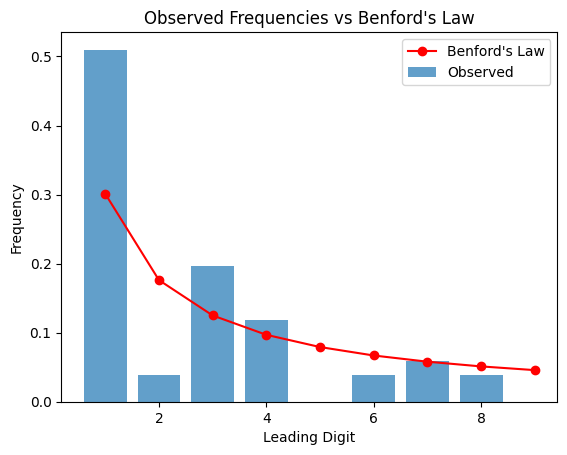

In [9]:
import matplotlib.pyplot as plt

# Collect observed frequencies for visualization
observed = digit_frequencies.collect()
observed = sorted(observed, key=lambda x: x[0])  # Sort by digit
observed_digits, observed_freqs = zip(*observed)

# Plot the observed vs expected
plt.bar(observed_digits, observed_freqs, label="Observed", alpha=0.7)
plt.plot(list(benford_frequencies.keys()), list(benford_frequencies.values()),
         label="Benford's Law", color='red', marker='o')
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Observed Frequencies vs Benford's Law")
plt.legend()
plt.show()
